# Data Processing

## Main

In [42]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

pd.set_option('display.max_columns', None)


path= os.path.abspath(glob.glob("**")[1]).replace("\\", '/' ) + "/" #! Path definition 
file_aero = 'Aerocivil.txt' #! File definition 
file_price = 'Precios.txt'

## Quantities

### Data Cleaning

In [62]:
# Processing of quantities table
p_f =  path + file_aero
data = pd.read_csv(p_f, sep="\t")
df =data
df = df.replace('(en blanco)', '0') 

df =df[['Año','Mes', 'CiudadDestino','Destino','Destino_MC',
        'NombreAeropuertoDestino','CiudadOrigen','Origen','Origen_MC', 
        'NombreAeropuertoOrigen','Leg', 'MarketLeg','Airline_Cod',
        'NombredeEmpresa','SiglaEmpresa','Trafico','TipoVuelo','Ruta_Viva',
        'NumerodeVuelos','PasajerosABordo','PasajerosTransito',
        'SillasOfrecidas','KM','LF','PDEWS','Weekly_Frequencies']]

df =df.sort_values(['Año','Mes','MarketLeg']).reset_index()

df[['KM',	'LF',	'PDEWS','Weekly_Frequencies']]=df[['KM',	'LF',	'PDEWS',
                                        'Weekly_Frequencies']].astype('string')


for x in ['KM',	'LF',	'PDEWS','Weekly_Frequencies']: 
  df[x]=df[x].apply(lambda x: x.replace(',', '.'))

  
df[['NumerodeVuelos',	'PasajerosABordo',	'PasajerosTransito',	
    'SillasOfrecidas','KM',	'LF',
    'PDEWS','Weekly_Frequencies']]=df[['NumerodeVuelos',	'PasajerosABordo',	
                                      'PasajerosTransito',	'SillasOfrecidas',
                                      'KM',	'LF','PDEWS',
                                      'Weekly_Frequencies']].astype('float')

df['Date'] = df['Mes'].astype('string')  + df['Año'].astype('string')
df['Date'] = pd.to_datetime(df['Date'], format='%m%Y')

# Creating data groups

df['Company'] = df['Airline_Cod'].apply(lambda x: 'Other' if x != 'AV'and
                                        x != 'LA' and
                                        x != 'VH' and
                                        x != 'VE'
                                      else ('Avianca' if x == 'AV' 
                                          else ('Latam' if x == 'LA' 
                                            else ('Viva' if x == 'VH' 
                                              else('Easy Fly' if x=='VE' 
                                                else 'no match')))))


df['Leg'] = df['Leg'].str.replace('EOH', 'MDE')
df['MarketLeg'] = df['MarketLeg'].str.replace('EOH', 'MDE')
df['Origen'] = df['Origen'].str.replace('EOH', 'MDE')
df['Destino'] = df['Destino'].str.replace('EOH', 'MDE')
df['CiudadDestino'] =df['CiudadDestino'].str.replace('RIONEGRO - ANTIOQUIA',
                                                    'MEDELLIN')
df['CiudadOrigen'] =df['CiudadOrigen'].str.replace('MEDELLIN', 
                                                  'RIONEGRO - ANTIOQUIA')
df['Ruta_Viva'] = (df['Ruta_Viva'].str.replace('Si', '1')).astype('float')


C:\Users\navas.LAPTOP-5SHC5PM9\AppData\Local\Temp\ipykernel_23624\4154963715.py:3: DtypeWarning: Columns (3,4,5,18,24,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(p_f, sep="\t")


### Data Sampling

In [63]:
# Creating df and df_full
# df is defined as a regular and national flight after 2021
df= df[(df['TipoVuelo'] == "R") & (df['Trafico'] == "N")  & (df['Año']>= 2021)].reset_index()
# Dropping Level_0
df.drop(['level_0'], axis=1, inplace = True)

# df_full is defined as a regular and national flight at any time in the observation data (from 2011-2022)
df_full = df[(df['TipoVuelo'] == "R") & (df['Trafico'] == "N")].reset_index()

# Changing the airline code of Ultra Air
df['Airline_Cod']=df['Airline_Cod'].replace('ULS', 'OL')

# Deleting airlines that are not listed in the pricing data
df = df[(df['Airline_Cod']!= 'CM') & (df['Airline_Cod']!= 'OTROS') ]

# We grouped the data to delete duplicates

df=df.groupby(['Año','Mes','Date', 'CiudadDestino','Destino','Destino_MC',
            'CiudadOrigen','Origen','Origen_MC','Leg' , 'MarketLeg',
            'Airline_Cod','Company','Trafico','TipoVuelo'] ,
            as_index=False).agg({'Ruta_Viva':'sum','NumerodeVuelos':'sum', 
                                'NumerodeVuelos':'sum',
                                'PasajerosABordo':'sum',
                                'PasajerosTransito':'sum',
                                'SillasOfrecidas':'sum',
                                'KM':'mean','LF':'mean',
                                'PDEWS':'mean','Weekly_Frequencies':'mean' })
    

df_full=df_full.groupby(['Año','Mes','Date', 'CiudadDestino','Destino',
                        'Destino_MC','CiudadOrigen','Origen','Origen_MC',
                        'Leg', 'MarketLeg','Airline_Cod','Company' ,
                        'Trafico','TipoVuelo'] ,
                        as_index=False).agg({'Ruta_Viva':'sum',
                                            'NumerodeVuelos':'sum', 
                                            'NumerodeVuelos':'sum',
                                            'PasajerosABordo':'sum',
                                            'PasajerosTransito':'sum',
                                            'SillasOfrecidas':'sum',
                                            'KM':'mean','LF':'mean',
                                            'PDEWS':'mean',
                                            'Weekly_Frequencies':'mean' })
# we reduce the sample to one-year observation level
df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M')
df = df[df['Date']>= '2021-02']



### New Variables and measures

In [65]:

# We create the HH index for passengers on board by route and period
mk_share_for_hhi = df.groupby(['Date','Leg','Airline_Cod'], 
                              as_index=False)['PasajerosABordo'].agg('sum')
                              
mk_share_for_hhi['id_HHI_treatment'] = mk_share_for_hhi['Date'].astype(str) + mk_share_for_hhi['Leg']
mk_share_for_hhi['id_m_share'] = mk_share_for_hhi['Date'].astype(str) + mk_share_for_hhi['Leg'] + mk_share_for_hhi['Airline_Cod']

consol_hhi =df.groupby(['Date', 'Leg'],
                      as_index=False)['PasajerosABordo'].agg('sum')

consol_hhi.rename(columns = {'PasajerosABordo':'PasajerosABordo_sum'}, 
                  inplace = True)

consol_hhi['id_HHI_treatment'] = consol_hhi['Date'].astype(str) + consol_hhi['Leg']
mk_share_for_hhi = mk_share_for_hhi.merge(consol_hhi, on='id_HHI_treatment', 
                                          how='left')

# We create the Market Share for passengers on board by airline, route and period
mk_share_for_hhi['m_share'] = (mk_share_for_hhi['PasajerosABordo']/ mk_share_for_hhi['PasajerosABordo_sum'])
df['id_m_share'] = df['Date'].astype(str) + df['Leg'] +df['Airline_Cod']
df_m_share = mk_share_for_hhi[['id_m_share', 'm_share']]
df = df.merge(df_m_share, on='id_m_share', how='left')



mk_share_for_hhi['HHI'] = (mk_share_for_hhi['m_share'].pow(2,axis=0))

mk_share_for_hhi = mk_share_for_hhi.groupby(['id_HHI_treatment','Date_x', 'Leg_x'], as_index=False)['HHI'].agg('sum')

df['id_HHI_treatment'] = df['Date'].astype(str) + df['Leg']
mk_share_for_hhi = mk_share_for_hhi[['id_HHI_treatment', 'HHI']]
df = df.merge(mk_share_for_hhi, on='id_HHI_treatment', how='left')


# We create the future treatment and pre-post variables by  route and period
df['OL_Presence'] =np.where(df['Airline_Cod'] == 'OL', 1, 0)
df['OL_entrance'] =np.where(df['Date'] > '2022-03', 1, 0)


treatment = df.groupby(['Date','Leg'], 
                      as_index=False)['OL_Presence','OL_entrance'].agg('sum')
TREATMENT = ['OL_Presence','OL_entrance']

for i in TREATMENT:
  treatment[i] = np.where(treatment[i]>=1,1,0)

df = df.drop(columns=['OL_Presence','OL_entrance'])


treatment_2 = treatment.groupby('Leg', as_index = False)['OL_Presence'].agg(sum)
TREATMENT_2 = ['OL_Presence']


for i in TREATMENT_2:
  treatment_2[i] = np.where(treatment_2[i]>=1,1,0)
  

treatment = treatment[[ 'OL_entrance', 'Leg', 'Date']]
treatment = treatment.merge(treatment_2, on='Leg', how='left')

treatment['id_HHI_treatment'] = treatment['Date'].astype(str) + treatment['Leg']
treatment = treatment[['id_HHI_treatment', 'OL_Presence','OL_entrance']]

df = df.merge(treatment, on='id_HHI_treatment', how='left')


C:\Users\navas.LAPTOP-5SHC5PM9\AppData\Local\Temp\ipykernel_23624\3825487084.py:40: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  treatment = df.groupby(['Date','Leg'],


## Prices

### Data Cleaning and sampling

In [66]:
#  Processing of prices table
p_f_p =  path + file_price
df_p = pd.read_csv(p_f_p, sep="\t")

df_p[['fullprice',	'Netprice', 'tax']]=df_p[['fullprice',	'Netprice', 'tax']].astype('string')

for x in ['fullprice',	'Netprice', 'tax']: 
  df_p[x]=df_p[x].apply(lambda x: x.replace(',', '.'))

df_p[['fullprice',	'Netprice', 'tax']]=round(df_p[['fullprice',	'Netprice', 'tax']].astype('float'),2)

df_p['ObservationDate'] = pd.to_datetime(df_p['ObservationDate'], format='%Y-%m-%d')
df_p['Depdate'] = pd.to_datetime(df_p['Depdate'], format='%Y-%m-%d')

df_p['Año'], df_p['Mes'], df_p['Dia'] = pd.to_datetime(df_p['Depdate']).dt.year, pd.to_datetime(df_p['Depdate']).dt.month, pd.to_datetime(df_p['Depdate']).dt.day
df_p['Month-Year'] =  pd.to_datetime(df_p['Depdate']).dt.to_period('M')

df_p['Leg'] = df_p['Leg'].str.replace('EOH', 'MDE')
df_p =df_p.sort_values(['Año','Mes','Leg']).reset_index()

# We sampling data from 2021-08 to 2022-08
df_p = df_p[(df_p['Month-Year']<='2022-08')]


### New Variables and Data grouping

In [67]:
# We create a new variable that indicates the number of days for the flight departure. 
df_p['Days for depature'] = ( df_p['ObservationDate']-df_p['Depdate'] )
df_p =df_p.sort_values(['Depdate','Days for depature'])
df_p['Days for depature']= df_p['Days for depature'].dt.days

# We grouped by month 
df_p = df_p.groupby(['Año','Mes','Month-Year','Carrier','Leg','Days for depature'], as_index=False)['Netprice','fullprice','tax'].agg('mean')

C:\Users\navas.LAPTOP-5SHC5PM9\AppData\Local\Temp\ipykernel_23624\849820958.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_p = df_p.groupby(['Año','Mes','Month-Year','Carrier','Leg','Days for depature'], as_index=False)['Netprice','fullprice','tax'].agg('mean')


## Joining quantities and prices

In [68]:
# We define new data frames
df_APP1 = df
df_p_month_day_APP1 = df_p


In [69]:
# We pivot the price data
df_p_month_day_pivot_APP1 = df_p_month_day_APP1.pivot( index =[ 'Año','Mes','Month-Year','Carrier',"Leg"], columns=['Days for depature'], values=['fullprice'])
df_p_month_day_pivot_APP1.columns = df_p_month_day_pivot_APP1.columns.droplevel(0) 
df_p_month_day_pivot_APP1.columns.name = None
df_p_month_day_pivot_APP1 = df_p_month_day_pivot_APP1.reset_index()

# We create an ID code (year + month + airline + route ) 
df_p_month_day_pivot_APP1['id'] = df_p_month_day_pivot_APP1['Año'].astype(str) + df_p_month_day_pivot_APP1['Mes'].astype(str) + df_p_month_day_pivot_APP1['Carrier'] +df_p_month_day_pivot_APP1['Leg']
df_APP1['id'] = df_APP1['Año'].astype(str) + df_APP1['Mes'].astype(str) + df_APP1['Airline_Cod'] +df_APP1['Leg']

# We condition the presence of data in our samples in order to develop the join exercise further.
df_APP1 = df_APP1[df_APP1['Leg'].isin(list(df_p.groupby('Leg', as_index = False).count()['Leg']))]
df_p_month_day_pivot_APP1 = df_p_month_day_pivot_APP1[df_p_month_day_pivot_APP1['id'].isin(list(df_APP1.groupby('id', as_index = False).count()['id']))]
df_APP1 = df_APP1[df_APP1['id'].isin(list(df_p_month_day_pivot_APP1.groupby('id', as_index = False).count()['id']))]

# We drop some columns that we do not use
df_p_month_day_pivot_APP1 = df_p_month_day_pivot_APP1.drop(columns=['Año','Mes','Month-Year','Carrier','Leg'])

# We join the Data
full_data_APP1 = pd.merge(df_APP1,df_p_month_day_pivot_APP1, on=["id","id"])
full_data_APP1= full_data_APP1.sort_values(['Date','Leg'])




### Data processing verification and export 




In [100]:

os.path.abspath(glob.glob('*/')[0]).replace("\\", '/' ).replace("/Data", '/Data_for_regresions_APP_1.xlsx' )

'c:/Users/navas.LAPTOP-5SHC5PM9/OneDrive - Universidad EAFIT/GitHub/Colombian-Air-Market-Data-Processing/Data_for_regresions_APP_1.xlsx'

In [ ]:

if full_data_APP1['id'].nunique()/ len(full_data_APP1)==1 :

  # To excel
  full_data_APP1.to_excel(os.path.abspath(glob.glob('*/')[0]).replace("\\", '/' ).replace("/Data", '/Data_for_regresions_APP_1.xlsx' ))
  # To stata
  full_data_APP1_to_stata = full_data_APP1
  full_data_APP1_to_stata['Date'] = full_data_APP1_to_stata['Año'].astype(str)+'-' +full_data_APP1_to_stata['Mes'].astype(str)
  full_data_APP1_to_stata.to_stata(os.path.abspath(glob.glob('*/')[0]).replace("\\", '/' ).replace("/Data", '/Data_for_regresions_APP_1.dta' ))

  print('The join exercise was successfully developed. We do not have duplicates')

else:
  print("We need to review de data processing. An error was made")

# STATA CODES AND PROCESSING

## Regressions: estimation and  Results

In [136]:
import stata_setup
#For windows 
stata_setup.config('C:/Program Files/Stata17/', 'mp')

# For linux 'uncomment' the following line
#stata_setup.config("/usr/local/stata17/", "mp")

In [ ]:
%%stata

global path  "`c(pwd)'"
use "$path\Data_for_regresions_APP_1.dta", clear

* # Creacion de variables
drop index
tostring A_o Mes, gen(A_o_s Mes_s)
gen idLEG = A_o_s + Mes_s + Leg
drop  A_o_s Mes_s
rename m_share ms
*CREEMOS EL FACTOR DE OCUPACION
gen of = PasajerosABordo/SillasOfrecidas

* # IDENTIFIQUEMOS CUALES SON LAS RUTAS QUE SIEMPRE SON UNICAS
preserve
egen HHI_1 = total(HHI==1) , by(Leg)
keep if HHI_1!=0 
collapse (mean) HHI, by(Leg)
keep if HHI==1
ren HHI index_HHI
save "$path\Leg_HHI_1_ever.dta", replace
restore

merge m:1 Leg using "$path\Leg_HHI_1_ever.dta", update replace
erase "$path\Leg_HHI_1_ever.dta"
drop _merge


* # IDENTIFIQUEMOS LAS PRINCIPALES RUTAS
preserve
use "$path\Data_for_regresions_APP_1_MONTH_LEG.dta", clear
rename id idLEG
egen rank= rank(-PasajerosABordo), by( Date)
gen top_30 = (rank<=30)
gen top_30_plus = (rank>30)
sort A_o Mes Leg rank
keep idLEG rank top_30 top_30_plus
save "$path\RANKS_FOR_LEG.dta", replace

restore
merge m:1 idLEG using "$path\RANKS_FOR_LEG.dta", update replace
erase "$path\RANKS_FOR_LEG.dta"
drop _merge


* # CREEMOS UNA VARIABLE PARA Alta y baja ocupacion
preserve
collapse (sum) PasajerosABordo SillasOfrecidas, by(Leg)
gen OF =PasajerosABordo/SillasOfrecidas
gen index_OF = (OF>=0.8)
keep Leg index_OF
save "$path\RANKS_FOR_LEG_OF.dta", replace
restore
merge m:1 Leg using "$path\RANKS_FOR_LEG_OF.dta", update replace
erase "$path\RANKS_FOR_LEG_OF.dta"
drop _merge


* # CREEMOS UN FORMATO PARA LA FECHA
gen Date_2 =mofd( date(Date,"YM"))
format Date_2 %tm
* CREEMOS UNA VARIABLE A PARTIR DE NOVIEMBRE
gen Date_after_nov = (Date_2 >= 742)

* # CREEMOS ID PARA LEG Y AEROLINEA
egen id_leg_car =  group( Leg Airline_Cod)
egen id_car =  group( Airline_Cod)
egen id_leg =  group( Leg)
xtset id_leg_car Date_2

* # CREATE Vars in LOG
gen ln_HHI = log(HHI)
forvalues i = 0(1)150 {
	capture noisily gen ln_`i' = log(_`i') 
}


* # creemos un rank de lideres de ruta
egen rank_MS= rank(-ms), by(Leg Date)
gen follower = (rank_MS!=1)


**# instrument regression selection

gen interact_OL =  OL_Presence*OL_entrance

**# OPTIONAL(new vars creations)
keep if index_HHI!=1
keep if Date_after_nov==1
gen Date_after_dic= (Date_2>= 743)
gen Date_after_jan= (Date_2>= 744)

* # REGRESIONES
				
matrix HAUSMANTEST=J(151,4,.)
			local row=1
			forvalues i = 0(1)150 {
					est clear
					capture noisily quietly ivreghdfe ln_`i' (ln_HHI = interact_OL ) , first ffirst savefirst  absorb(id_leg Date_2) 
					capture noisily mat HAUSMANTEST[`row',3] = e(widstat)
					capture noisily mat HAUSMANTEST[`row',4] = e(N)
					capture noisily estimates store iv_reg
					capture noisily quietly reghdfe ln_`i' ln_HHI , absorb(id_leg Date_2 )
					capture noisily estimates store noiv_reg
					capture noisily hausman iv_reg noiv_reg	
					capture noisily mat HAUSMANTEST[`row',1] = r(p)
					capture noisily sum interact_OL if ln_`i'!=.
					capture noisily mat HAUSMANTEST[`row',2] = r(mean)

				local row = `row'+1
				
			}				
				
matsave HAUSMANTEST, replace saving path("$path/ESTADISTICAS_RUTAS")



global LNHHI_IV_1  ""(ln_HHI = interact_OL ) " "(ln_HHI = interact_OL ) if  Date_after_dic==1 " "(ln_HHI = interact_OL ) if Date_after_jan==1 "   "(ln_HHI = interact_OL ) if (top_30==1 )" "(ln_HHI = interact_OL ) if (top_30_plus==1 )" "(ln_HHI = interact_OL ) if rank_MS==1  " "(ln_HHI = interact_OL ) if rank_MS!=1  " "(ln_HHI = interact_OL ) if index_OF!=1  " "(ln_HHI = interact_OL ) if index_OF==1  "" 


global FE ""id_leg""
global RC ""robust""


global REG "$LNHHI_IV_1"

foreach rc in $RC {
	foreach fe in $FE {
		foreach p in $REG {
			
			local replace replace
			forvalues i = 0(1)150 {
					capture noisily quietly ivreghdfe ln_`i' `p' , first ffirst savefirst  absorb(`fe' Date_2) `rc' 
					capture noisily quietly estimates replay _ivreg2_ln_HHI
					local w : display %9.4f r(table)["b", "interact_OL"]
					local w2 : display %9.4f r(table)["se", "interact_OL"]
					local w3 : display %9.4f r(table)["t", "interact_OL"]
					local w4 : display %9.4f r(table)["pvalue", "interact_OL"]
					local w5 : display %9.4f r(table)["ll", "interact_OL"]
					local w6 : display %9.4f r(table)["ul", "interact_OL"]
					regsave ln_HHI using "$path/Regressions_Results/reg_1_`fe'_`rc'_`p'.dta", ci level(90) addlabel(lags, _`i',F, `e(widstat)', coef_f1, `w', se, `w2', t_value, `w3', pvalue, `w4', ll, `w5', ul, `w6') `replace'
					local replace append 
				}
		}
	}
}

local filenames : dir "$path\Regressions_Results" files "*.dta"
	
	foreach f in `filenames' {
			
		use "$path\Regressions_Results\\`f'", replace
		replace lags = subinstr(lags, "_", "-",.)
		destring lags, replace
		sum(F)
		local w : display %9.4f r(mean)
		twoway  (rcap ci_lower ci_upper lags, fcolor(none)  lcolor(gray)) (scatter coef 	lags, mcolor(black) msize(small) 			///
		lcolor(black)), legend(order(2 "Coeff" 1 "90% CI") region(lwidth(none))) 		///
		yline(0) xscale(range(0, -150)) xlabel(0(10)-150)  graphregion(color(white)) 		///
		ytitle(coefficient) xtitle(Lags, m(medsmall)) yscale(range(-1, 1.5)) ylabel(-1(0.5)1.5) caption("{bf:First stage F-value}: `w'", size(*0.75))
		local fnew = subinstr("`f'",".dta",".png",.)
		graph export  "$path\Regressions_Graphs\\`fnew'", replace
	
	}
	




## Analytics and Empirical test

In [ ]:
%%stata

# /*

# ESTE CODIGO SE DEBE CORRER DESPUES DE LAS REGRESIONES

# Este codigo tiene como objetivo crear todas las estadisticas descriptivas  y empiricas
# de la estrategia de identificacion (tendecias paralelas y diseno de estudio de evento)





# */
global path  "`c(pwd)'"
use "$path\Data_for_trends.dta", clear

* Creacion de variables
drop index
drop if Airline_Cod=="AA"
drop if Airline_Cod=="9A"
tostring A_o Mes, gen(A_o_s Mes_s)
gen idLEG = A_o_s + Mes_s + Leg
drop  A_o_s Mes_s
rename m_share ms



* CREEMOS UN FORMATO PARA LA FECHA
gen Date_2 =mofd( date(Date,"YM"))
format Date_2 %tm


In [ ]:
%%stata
* # TEDENCIAS PARALELAS
preserve
collapse (mean) HHI (sem) m_HHI= HHI, by(Date_2 OL_Presence)
keep if Date_2>=735
gen U_B = HHI+ m_HHI
gen L_B = HHI - m_HHI
twoway(rarea  U_B L_B Date_2 if OL_Presence==1,   fcolor(navy) lwidth(none)  fintensity(30)) (rarea  U_B L_B Date_2 if OL_Presence==0, fcolor(gray) lwidth(none)  fintensity(30)) (line HHI Date_2 if OL_Presence==0, lcolor(gray)) (line HHI Date_2 if OL_Presence==1, lcolor(navy)) ,  legend(order(4 "Treatment group routes" 3 "Control group routes") region(lwidth(none))) 		///
		yline(0, lcolor(black)) xline(745)  graphregion(color(white)) 		///
		ytitle("HHI") xtitle(Date, m(medsmall))  caption("{bf:Note}: The vertical line indicates Ultra's entry into the market (in February 2022)", size(*0.75))
		
restore

In [ ]:

%%stata
preserve
* # COMO ES EL EFECTO DE LA ENTRADA DE RUTA A NIVEL RUTA
collapse (mean) HHI (sem) m_HHI= HHI, by(Date_2 OL_Presence MarketLeg)
keep if Date_2>=735
gen U_B = HHI+ m_HHI
gen L_B = HHI - m_HHI
keep if OL_Presence==1


		
xtline HHI , i(MarketLeg) t(Date_2) overlay  legend(region(lwidth(none)))  xline(745) 

restore



In [ ]:
%%stata
preserve 
keep if Date_2>=735
collapse (sum) PasajerosABordo (mean) HHI  (sem) m_HHI= HHI, by(OL_entrance OL_Presence MarketLeg)
egen rank= rank(-PasajerosABordo), by(OL_entrance)
gen U_B = HHI+ m_HHI
gen L_B = HHI - m_HHI

twoway (scatter HHI rank if (OL_entrance==0 & OL_Presence==1))(qfit HHI rank if (OL_entrance==0 & OL_Presence==1))(scatter HHI rank if (OL_entrance==1 & OL_Presence==1) ) (qfit HHI rank if (OL_entrance==1 & OL_Presence==1)) (rcap L_B U_B rank if OL_Presence==1, fcolor(none)  lcolor(gray)), legend(order(1 "Pretreatment" 3 "Postreatment" 2 "Pretreatment trend" 4 "Postreatment trend") region(lwidth(none))) 		///
		   graphregion(color(white)) 		///
		ytitle("HHI (mean)") xtitle(Rank, m(medsmall)) title( "Treatment Group")
		


keep if HHI!=1
		
twoway (scatter HHI rank if (OL_entrance==0 & OL_Presence==0))(qfit HHI rank if (OL_entrance==0 & OL_Presence==0))(scatter HHI rank if (OL_entrance==1 & OL_Presence==0) ) (qfit HHI rank if (OL_entrance==1 & OL_Presence==0)) (rcap L_B U_B rank if OL_Presence==0, fcolor(none)  lcolor(gray)), legend(order(1 "Pretreatment" 3 "Postreatment" 2 "Pretreatment trend" 4 "Postreatment trend") region(lwidth(none))) 		///
		   graphregion(color(white)) 		///
		ytitle("HHI (mean)") xtitle(Rank, m(medsmall)) 
		


restore


## Other Graphs


In [ ]:
%%stata
# /*
# Este codigo tiene como objetivo crear todas las estadisticas descriptivas  de market shares, pasajeros y sillas

# */

global path  "`c(pwd)'"
use "$path\Data_for_trends.dta", clear

* Creacion de variables
drop index
drop if Airline_Cod=="AA"
drop if Airline_Cod=="9A"
tostring A_o Mes, gen(A_o_s Mes_s)
gen idLEG = A_o_s + Mes_s + Leg
drop  A_o_s Mes_s
rename m_share ms


* CREEMOS UN FORMATO PARA LA FECHA
gen Date_2 =mofd( date(Date,"YM"))
format Date_2 %tm



In [ ]:
%%stata 

preserve
egen tot_pas =  total (PasajerosABordo), by(Date_2 Leg)
keep Airline_Cod Leg Date_2  ms tot_pas
reshape wide ms, i(Leg Date_2 tot_pas ) j(Airline_Cod) string

global w "ms9R msAV msLA msOL msP5 msVE msVH"
 
foreach i in $w {
	replace `i' = 0 if `i' ==.
	
}
reshape long ms, i(Leg Date_2 tot_pas ) j(Airline_Cod) string
collapse (mean) ms (sem) m_ms = ms [fw=tot_pas], by(Date_2  Airline_Cod)

gen U_B = ms+ m_ms
gen L_B = ms - m_ms
replace ms = .  if ms==0
replace ms = ms*100

twoway(line  ms Date_2 if Airline_Cod=="AV",   lcolor(cranberry) lwidth(medthick)) (line  ms Date_2 if Airline_Cod=="VH", lcolor(gold)  lwidth(medthick) ) (line  ms Date_2 if Airline_Cod=="LA",   lcolor(midblue)  lwidth(medthick) ) (line  ms Date_2 if Airline_Cod=="VE",   lcolor(green)  lwidth(medthick)) (line  ms Date_2 if Airline_Cod=="OL",  lwidth(medthick)  lcolor(orange)) ,  legend(order(1 "Avianca" 2 "Viva" 3 "Latam" 4 "Easy Fly" 5 "Ultra")  lwidth(medthick) region(lwidth(none))) 		///
		    graphregion(color(white)) 		///
		ytitle("Market Share") xtitle(Date, m(medsmall)) 
		
restore


In [ ]:
%%stata
preserve
egen tot_pas =  total (PasajerosABordo), by(Date_2 Leg)
keep Airline_Cod Leg Date_2  PasajerosABordo SillasOfrecidas tot_pas
reshape wide PasajerosABordo SillasOfrecidas, i(Leg Date_2 tot_pas ) j(Airline_Cod) string

global w "PasajerosABordo9R PasajerosABordoAV PasajerosABordoLA PasajerosABordoOL PasajerosABordoP5 PasajerosABordoVE PasajerosABordoVH SillasOfrecidas9R SillasOfrecidasAV SillasOfrecidasLA SillasOfrecidasOL SillasOfrecidasP5 SillasOfrecidasVE SillasOfrecidasVH"

 
foreach i in $w {
	replace `i' = 0 if `i' ==.
	
}

reshape long PasajerosABordo SillasOfrecidas, i(Leg Date_2 tot_pas ) j(Airline_Cod) string

collapse (mean) PasajerosABordo SillasOfrecidas (sem) m_PasajerosABordo = PasajerosABordo  m_SillasOfrecidas = SillasOfrecidas [fw=tot_pas], by(Date_2 )

gen U_B = PasajerosABordo+ m_PasajerosABordo
gen L_B = PasajerosABordo - m_PasajerosABordo

twoway(line  PasajerosABordo Date_2 ,   lcolor(cranberry) lwidth(medthick)) (line  SillasOfrecidas Date_2 , lcolor(midblue)  lwidth(medthick) )  ,  legend(order(1 "Passengers " 2 "Offered  seats" )  lwidth(medthick) region(lwidth(none))) 		///
		    graphregion(color(white)) 		///
		ytitle("Passengers | Seats (mean) ") xtitle(Date, m(medsmall)) 
		

restore

In [ ]:


%%stata
preserve
collapse (sum) PasajerosABordo SillasOfrecidas, by(Date_2)
replace PasajerosABordo = PasajerosABordo/1000000
replace SillasOfrecidas = SillasOfrecidas/1000000


twoway(line  PasajerosABordo Date_2 ,   lcolor(cranberry) lwidth(medthick)) (line  SillasOfrecidas Date_2 , lcolor(midblue)  lwidth(medthick) )  ,  legend(order(1 "Passengers " 2 "Offered  seats" )  lwidth(medthick) region(lwidth(none))) 		///
		    graphregion(color(white)) 		///
		ytitle(Passengers | Seats (in millions), size(medsmall)) xtitle(Date, m(medsmall)) 

restore

## Other graphs and statistics

In [147]:
%%stata
**# Main
global path  "`c(pwd)'"
use "$path\Data_for_regresions_APP_1.dta", clear


* Creacion de variables
drop index
tostring A_o Mes, gen(A_o_s Mes_s)
gen idLEG = A_o_s + Mes_s + Leg
drop  A_o_s Mes_s
rename m_share ms

* IDENTIFIQUEMOS CUALES SON LAS RUTAS QUE SIEMPRE SON UNICAS
preserve
egen HHI_1 = total(HHI==1) , by(Leg)
keep if HHI_1!=0 
collapse (mean) HHI, by(Leg)
keep if HHI==1
ren HHI index_HHI
save "$path\Leg_HHI_1_ever.dta", replace
restore

merge m:1 Leg using "$path\Leg_HHI_1_ever.dta", update replace
erase "$path\Leg_HHI_1_ever.dta"
drop _merge


* CREEMOS UN FORMATO PARA LA FECHA
gen Date_2 =mofd( date(Date,"YM"))
format Date_2 %tm



. **# Main
. global path  "`c(pwd)'"

. use "$path\Data_for_regresions_APP_1.dta", clear

. 
. 
. * Creacion de variables
. drop index

. tostring A_o Mes, gen(A_o_s Mes_s)
A_o_s generated as str4
Mes_s generated as str2

. gen idLEG = A_o_s + Mes_s + Leg

. drop  A_o_s Mes_s

. rename m_share ms

. 
. * IDENTIFIQUEMOS CUALES SON LAS RUTAS QUE SIEMPRE SON UNICAS
. preserve

. egen HHI_1 = total(HHI==1) , by(Leg)

. keep if HHI_1!=0 
(2,472 observations deleted)

. collapse (mean) HHI, by(Leg)

. keep if HHI==1
(10 observations deleted)

. ren HHI index_HHI

. save "$path\Leg_HHI_1_ever.dta", replace
(file c:\Users\navas.LAPTOP-5SHC5PM9\OneDrive - Universidad
    EAFIT\GitHub\Colombian-Air-Market-Data-Processing\Leg_HHI_1_ever.dta not
    found)
file c:\Users\navas.LAPTOP-5SHC5PM9\OneDrive - Universidad
    EAFIT\GitHub\Colombian-Air-Market-Data-Processing\Leg_HHI_1_ever.dta
    saved

. restore

. 
. merge m:1 Leg using "$path\Leg_HHI_1_ever.dta", update replace

    Result           

### Statistics

In [148]:
%%stata


* ESTADISTICAS DE ALGUNAS VARIABLES
preserve
gen Leg_2 =  CiudadOrigen +" to " +CiudadDestino
collapse (sum) PasajerosABordo, by(Leg index_HHI Leg_2)
egen Tot_market  = total( PasajerosABordo)
keep if index_HHI==1
ren Leg Ruta
ren Leg_2 Nombre
ren PasajerosABordo Pasajeros
gen Porcentaje =  (Pasajeros/Tot_market)
keep Ruta Nombre Porcentaje
export excel using "$path/ESTADISTICAS_RUTAS/estadistics_leg_HHI.xlsx", firstrow(variables) replace
restore

preserve
gen Leg_2 =  CiudadOrigen +" to " +CiudadDestino
collapse (sum) PasajerosABordo, by(Leg OL_Presence Leg_2)
egen Tot_market  = total( PasajerosABordo)
keep if OL_Presence==1
ren Leg Ruta
ren Leg_2 Nombre
ren PasajerosABordo Pasajeros
gen Porcentaje =  (Pasajeros/Tot_market)
keep Ruta Nombre Porcentaje
export excel using "$path/ESTADISTICAS_RUTAS/estadistics_leg_Entrada_Ultra.xlsx", firstrow(variables) replace
restore


outreg2 using "$path/ESTADISTICAS_RUTAS/ESTADISTICAS.xlsx",  replace sum(log) eqkeep(N mean median min max sd) keep(NumerodeVuelos PasajerosABordo SillasOfrecidas LF ms)


preserve
collapse (sum) PasajerosABordo, by(Leg Airline_Cod)
egen leg_count = count(Airline_Cod), by(Leg)
keep if leg_count!=1
collapse (mean) leg_count, by(Leg)
outreg2 using "$path/ESTADISTICAS_RUTAS/ESTADISTICAS.xlsx",  append sum(log) eqkeep(N mean median min max sd) keep(leg_count)
restore

preserve
collapse (mean) HHI, by(Leg Date_2)
keep if HHI!=1
outreg2 using "$path/ESTADISTICAS_RUTAS/ESTADISTICAS.xlsx",  append sum(log) eqkeep(N mean median min max sd) keep(HHI)
restore



. 
. 
. * ESTADISTICAS DE ALGUNAS VARIABLES
. preserve

. gen Leg_2 =  CiudadOrigen +" to " +CiudadDestino

. collapse (sum) PasajerosABordo, by(Leg index_HHI Leg_2)

. egen Tot_market  = total( PasajerosABordo)

. keep if index_HHI==1
(74 observations deleted)

. ren Leg Ruta

. ren Leg_2 Nombre

. ren PasajerosABordo Pasajeros

. gen Porcentaje =  (Pasajeros/Tot_market)

. keep Ruta Nombre Porcentaje

. export excel using "$path/ESTADISTICAS_RUTAS/estadistics_leg_HHI.xlsx", first
> row(variables) replace
file c:\Users\navas.LAPTOP-5SHC5PM9\OneDrive - Universidad EAFIT\GitHub\Colombi
> an-Air-Market-Data-Processing/ESTADISTICAS_RUTAS/estadistics_leg_HHI.xlsx sav
> ed

. restore

. 
. preserve

. gen Leg_2 =  CiudadOrigen +" to " +CiudadDestino

. collapse (sum) PasajerosABordo, by(Leg OL_Presence Leg_2)

. egen Tot_market  = total( PasajerosABordo)

. keep if OL_Presence==1
(68 observations deleted)

. ren Leg Ruta

. ren Leg_2 Nombre

. ren PasajerosABordo Pasajeros

. gen Porcentaj

### Graphs


. *RELACION ENTRE FACTOR DE OCUPACION Y RANKING EN LAS RUTAS
. preserve

. collapse (sum) PasajerosABordo SillasOfrecidas, by (Leg)

. gen OF = PasajerosABordo/SillasOfrecidas

. egen rank= rank(-PasajerosABordo)

. twoway (scatter OF rank )(qfit OF rank), legend(order(2 "trend" ) region(lwid
> th(none)))                 ///
>                 yline(0, lcolor(black)) yline(0.1)   graphregion(color(white)
> )          ///
>                 ytitle("Occupancy Factor") xtitle(Rank, m(medsmall)) 

. restore

. 
. 


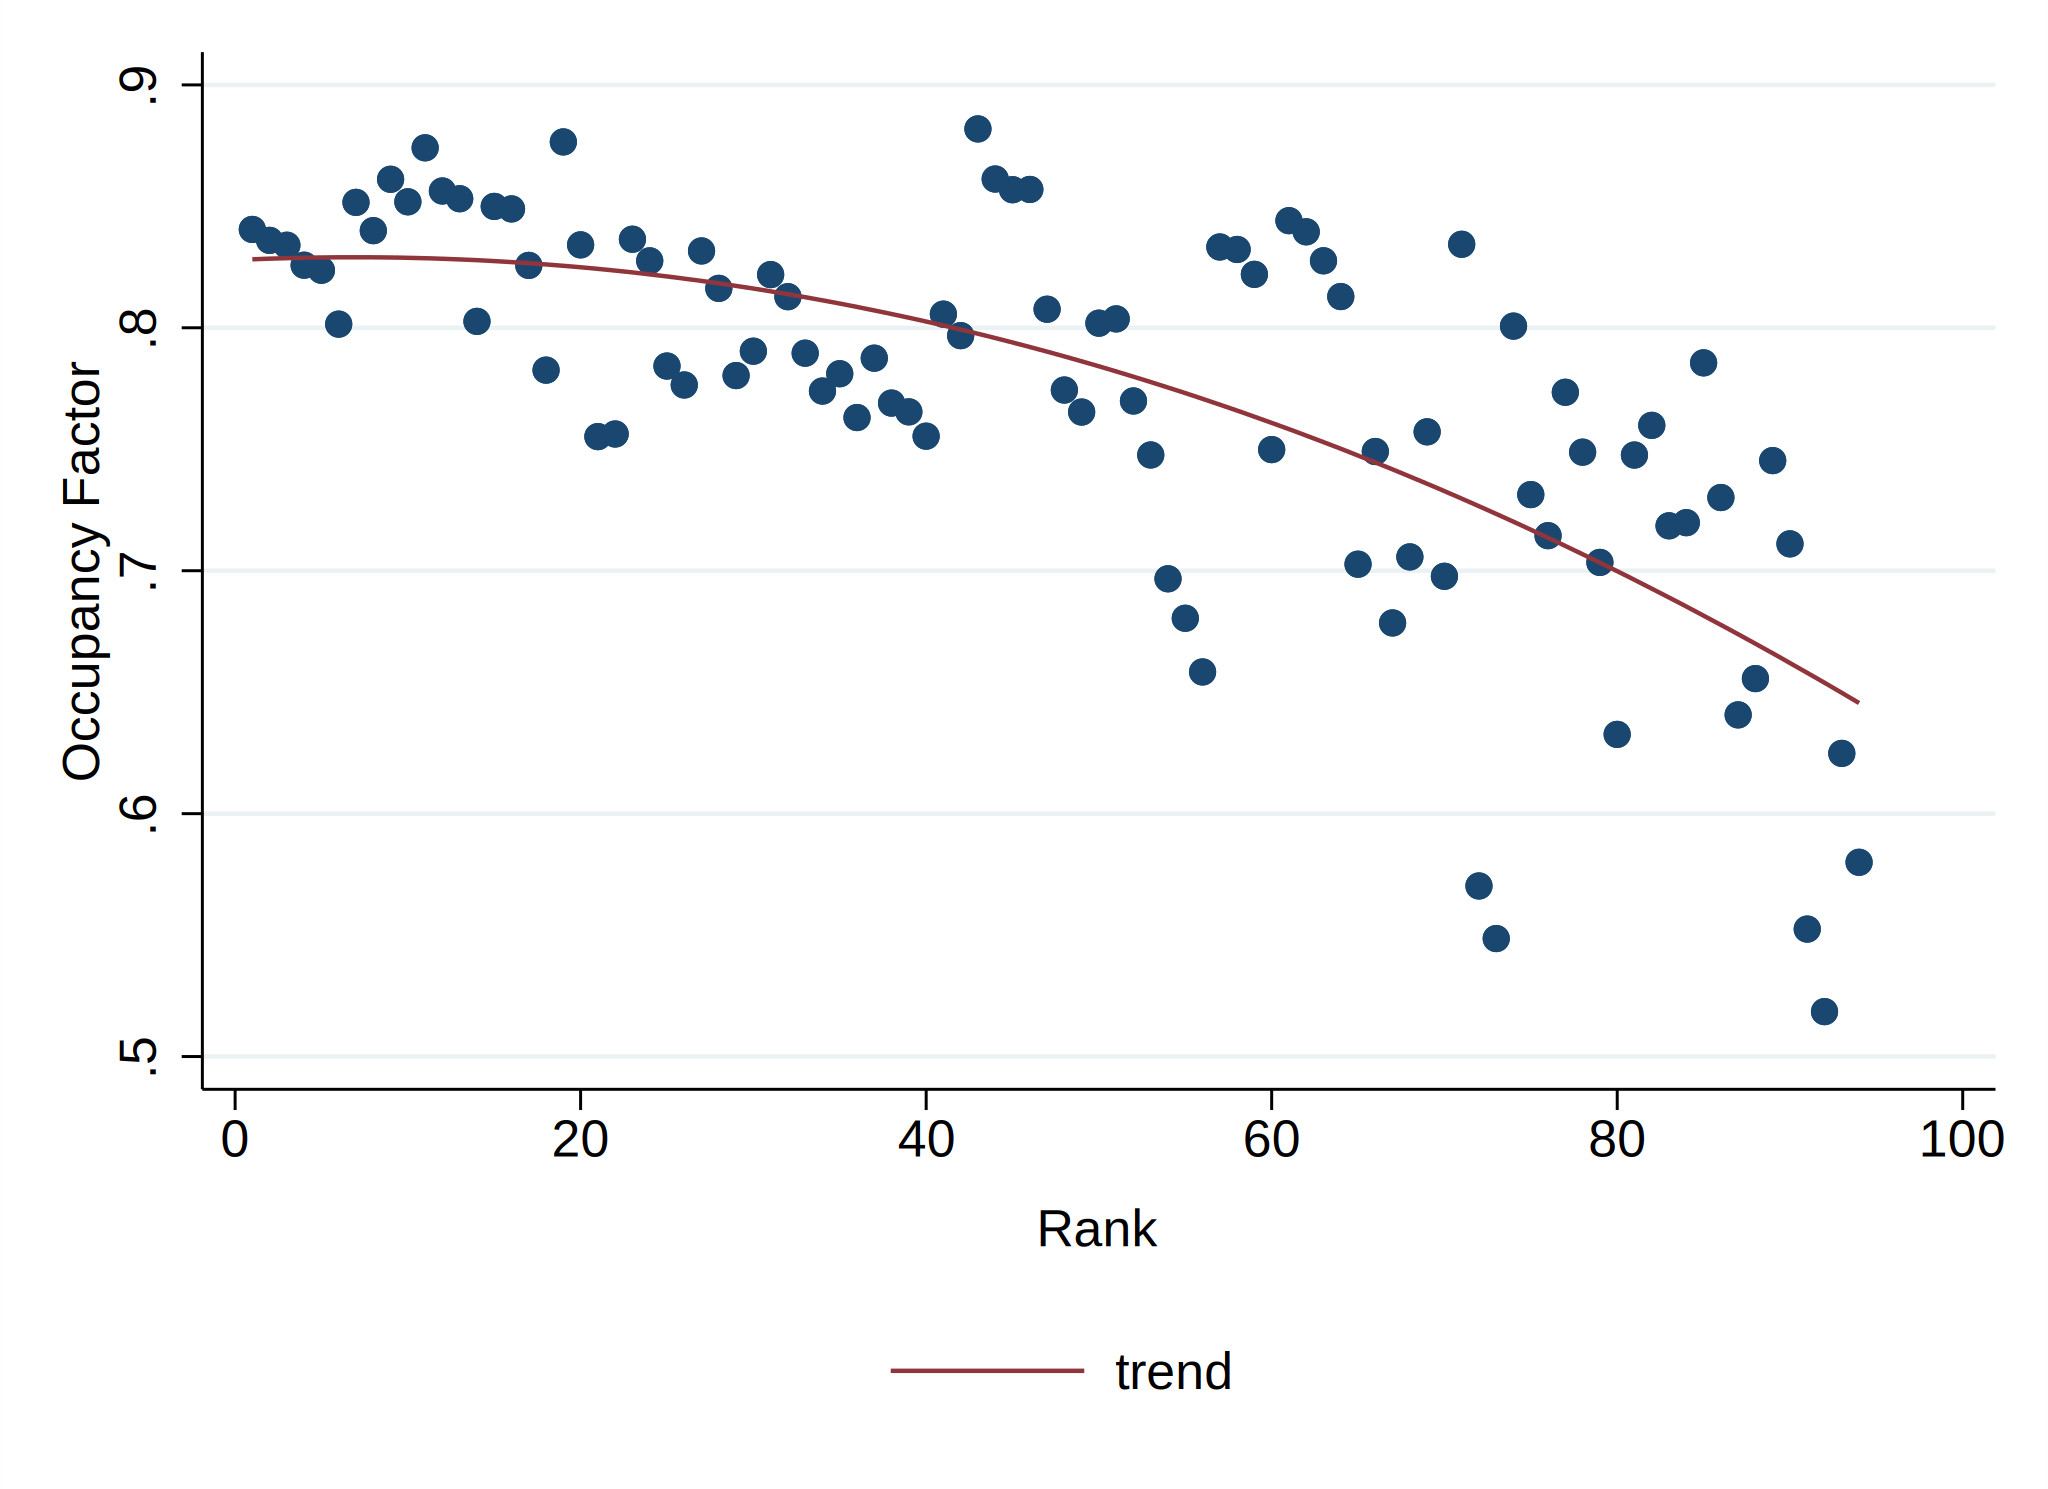

In [149]:
%%stata
*RELACION ENTRE FACTOR DE OCUPACION Y RANKING EN LAS RUTAS
preserve
collapse (sum) PasajerosABordo SillasOfrecidas, by (Leg)
gen OF = PasajerosABordo/SillasOfrecidas
egen rank= rank(-PasajerosABordo)
twoway (scatter OF rank )(qfit OF rank), legend(order(2 "trend" ) region(lwidth(none))) 		///
		yline(0, lcolor(black)) yline(0.1)   graphregion(color(white)) 		///
		ytitle("Occupancy Factor") xtitle(Rank, m(medsmall)) 
restore




. preserve 

.  use "$path\ESTADISTICAS_RUTAS\HAUSMANTEST.dta" , clear

.   gen lags = _n-1

.   replace lags = -lags
(150 real changes made)

.   keep if (c1!=.)
(38 observations deleted)

.   keep if (c1!=1)
(1 observation deleted)

. gen reject = (c1<=0.1)

. *HUASMAN
. twoway  (scatter c1     lags, mcolor(black) msize(small)                     
>    ///
>                 lcolor(black)), legend(order(2 "Coeff" 1 "90% CI") region(lwi
> dth(none)))                ///
>                 yline(0, lcolor(black)) yline(0.1) xscale(range(0, -150)) xla
> bel(0(10)-150)  graphregion(color(white))          ///
>                 ytitle("P-value") xtitle(Lags, m(medsmall)) yscale(range(0, 1
> )) ylabel(0(0.1)1) caption("{bf:Note}: 0.1 red line indicates de 90% confiden
> ce level", size(*0.75))

. *HAUSMAN BINARY APP             
. twoway  (scatter reject         lags, mcolor(black) msize(small)             
>            ///
>                 lcolor(black)), legend(order(2 "Coeff" 1 "90% CI") 

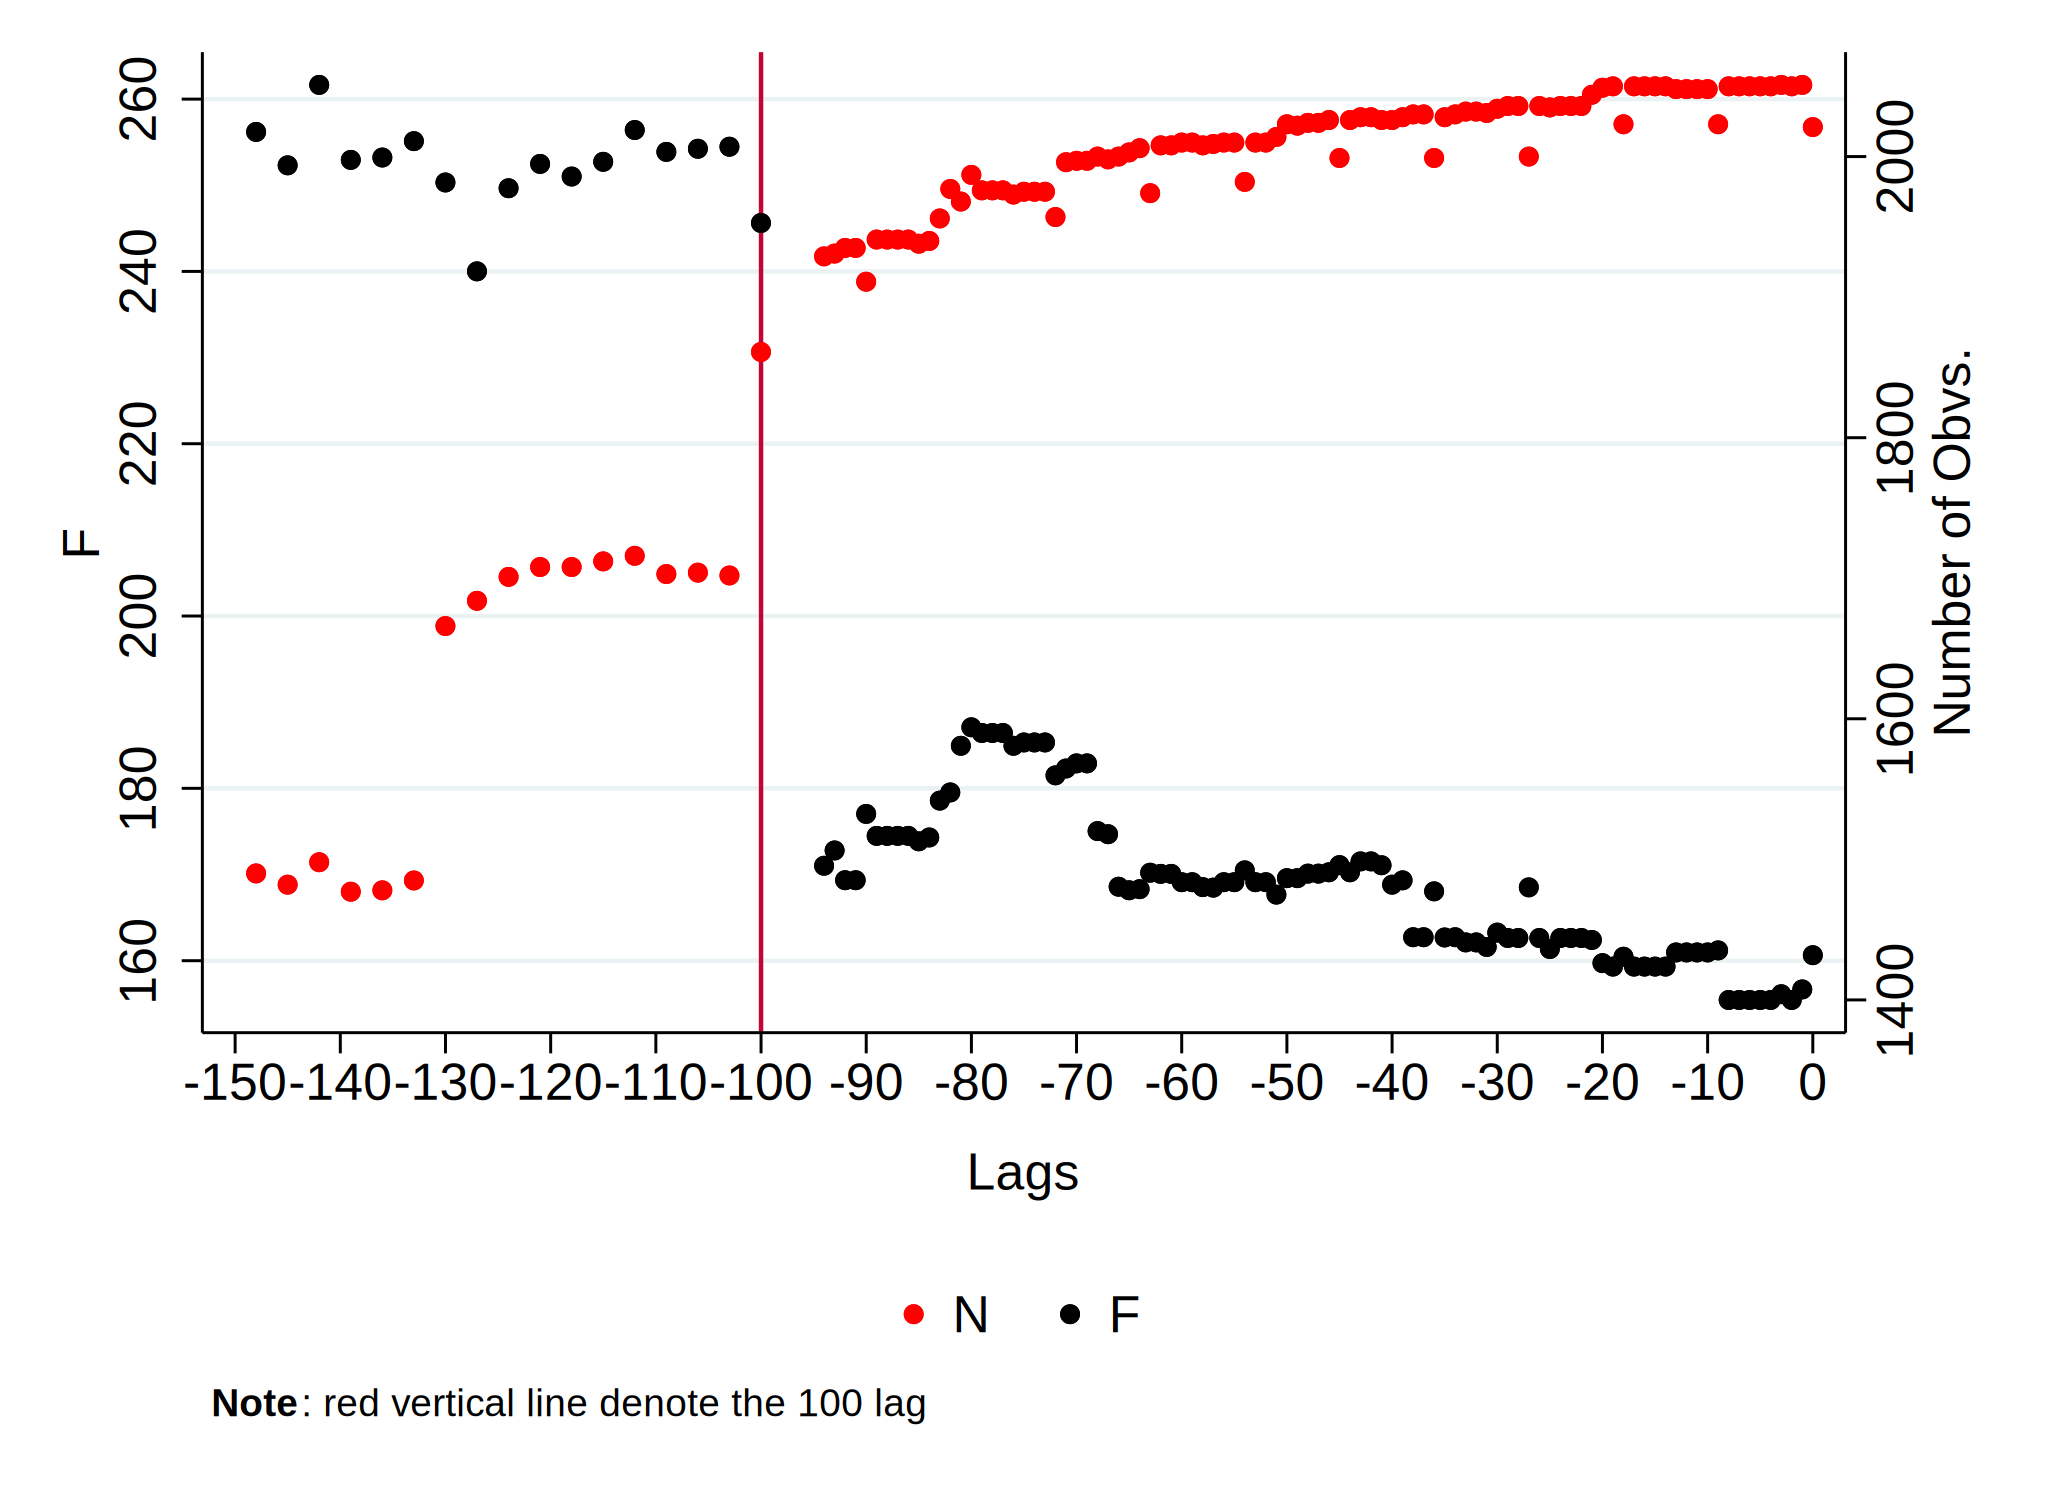

In [150]:
%%stata
preserve 
 use "$path\ESTADISTICAS_RUTAS\HAUSMANTEST.dta" , clear
  gen lags = _n-1
  replace lags = -lags
  keep if (c1!=.)
  keep if (c1!=1)
gen reject = (c1<=0.1)
*HUASMAN
twoway  (scatter c1 	lags, mcolor(black) msize(small) 			///
		lcolor(black)), legend(order(2 "Coeff" 1 "90% CI") region(lwidth(none))) 		///
		yline(0, lcolor(black)) yline(0.1) xscale(range(0, -150)) xlabel(0(10)-150)  graphregion(color(white)) 		///
		ytitle("P-value") xtitle(Lags, m(medsmall)) yscale(range(0, 1)) ylabel(0(0.1)1) caption("{bf:Note}: 0.1 red line indicates de 90% confidence level", size(*0.75))
*HAUSMAN BINARY APP		
twoway  (scatter reject 	lags, mcolor(black) msize(small) 			///
		lcolor(black)), legend(order(2 "Coeff" 1 "90% CI") region(lwidth(none))) 		///
		yline(0, lcolor(black)) yline(0.1) xscale(range(0, -150)) xlabel(0(10)-150)  graphregion(color(white)) 		///
		ytitle("P-value") xtitle(Lags, m(medsmall)) yscale(range(0, 1)) ylabel(0(1)1) caption("{bf:Note}: if value is equal 1 the null hypothesis of Hausman test is rejected at 90% confidence level", size(*0.75))
* N Vs F		
twoway  (scatter c3 	lags, mcolor(black) msize(small) 			///
		lcolor(black) yaxis(1)) (scatter c4 	lags, mcolor(red) msize(small) 			///
		lcolor(black) yaxis(2)), legend(order(2 "N" 1 "F") region(lwidth(none))) 		///
		  xscale(range(0, -150)) xlabel(0(10)-150)  graphregion(color(white)) 		///
		ytitle("F") ytitle("Number of Obvs.", axis(2)) xline(-100) xtitle(Lags, m(medsmall)) caption("{bf:Note}: red vertical line denote the 100 lag", size(*0.75))
  
restore
